# Project: Continuous Control
---
In this notebook, you will implement an actor-critic agent to solve Unity Environment's Reacher environment.

### 1. Import necessary packages
1. We import some basic libraries such as Numpy, torch,copy, datetime, namedtuple, deque, and matplotlib. 
1. We import Pytorch libraries for neural networks. 
1. We import UnityEnvironment that will allow us to interact with the Banana Environment. 
1. We define a device variable that operates the code on GPU if GPU is available.

In [1]:
import random
import torch
import numpy as np
import copy
import datetime
from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from unityagents import UnityEnvironment

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Instantiate the Environment
Next, we will start the environment!  **_Before running the code cell below_**, change the `Environment_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
Environment_name = "Reacher.exe"
```

In [2]:
Environment_name = "Reacher_1_Windows_x86_64\Reacher.exe"
env = UnityEnvironment(file_name=Environment_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)
print(brain)

ReacherBrain
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Explore the Environment

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
tmax = 200
for _ in range(tmax):
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


### 5. Build Our Actor and Critic Networks

The Neural Network models we are going to use consist of fully connected layers only as the state space is not pixels.


In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 6. Build Our Actor-Critic Agent

We define a class called `ReplayBuffer` that holds the memory of past experiences.

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

We define a class called `OUNoise` that creates a sample of Ornstein-Uhlenbeck noise process that will be added on actions to provide exploration.

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(len(x))
        self.state = x + dx
        return self.state

- The agent will use the actor and critic models we built to make 2 identical Neural Networks of each:
    1. Local actor Neural Network: This will be updated every epoch
    1. Target actor Neural Network: This will be soft-updated with the value of the local neural network
    1. Local critic Neural Network: This will be updated every epoch
    1. Target critic Neural Network: This will be soft-updated with the value of the local neural network


- The hyper parameters in the agent will be:
    1. `BUFFER_SIZE` - Size of the pool of past experiences the agent will choose from
    1. `BATCH_SIZE` - Minibatch size
    1. `GAMMA` - Discount factor &gamma;
    1. `TAU` - Soft updae parameter &tau;
    1. `LR_ACTOR` - Learning rate parameter for the actor network
    1. `LR_CRITIC` - Learning rate parameter for the critic network
    1. `WEIGHT_DECAY` - L2 weight decay

In [9]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

LEARN_UPDATES = 10          # number of learning updates
TIME_STEPS_TO_LEARN = 20    # every n time step do update

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, time_step, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # only learn every n_time_steps
        if time_step % TIME_STEPS_TO_LEARN != 0:
            return
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            for _ in range(LEARN_UPDATES):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            state = state.unsqueeze(0)
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### 7. Train one Agent

Define a function `actor_critic_train_one` that trains the agent.

__Note:__ the reward was modified so that it is `1` if the agent is touching the target and `0` if it's not. The original reward gives a very small reward, nearly `0.003`, which is very small so the agent didn't learn anything.


In [10]:
def actor_critic_train_one(env, agent, scores, n_episodes=2000, max_t=1000, add_noise=True, max_score=30):
    """Deep Q-Learning.
    
    Params
    ======
        env (Environment_variable) : an instance of the enivronment class
        agent (agent_variable) : an instance of the agent class
        scores (list) : an empty list to hold the scores
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        add_noise (boolean): whether or not provide noise for exploration
        max_score (int): the maximum average reward over 100 episodes at which the training stops
    """
    scores_window = deque(maxlen=100)  # last 100 scores
    brain_name = env.brain_names[0]
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        agent.reset()                                      # Reset Noise
        score = 0
        for t in range(max_t):
            action = agent.act(state, add_noise)           # choose the apropriate action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = 1.0 if env_info.rewards[0] > 0 else 0.0
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(t, state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tScore {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tScore {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)))
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), "checkpoint_actor.pth")
            torch.save(agent.critic_local.state_dict(), "checkpoint_critic.pth")
        if np.mean(scores_window)>=max_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), "checkpoint_actor.pth")
            torch.save(agent.critic_local.state_dict(), "checkpoint_critic.pth")
            break

Run the cell below to begin training

In [11]:
# Choose default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Determine state and action sizes
env_info = env.reset(train_mode=True)[brain_name]
state_size = len(env_info.vector_observations[0])
action_size = brain.vector_action_space_size

# Instatiate the agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1234)

# Define training parameters
n_episodes=500          # maximum number of training episodes
max_t=int(1000)         # maximum number of timesteps per episode
add_noise=True          # whether or not provide noise for exploration
max_score=500           # the maximum average reward over 100 episodes at which the training stops

# Begin training
scores = []
actor_critic_train_one(env, agent, scores, n_episodes=n_episodes, max_t=max_t, add_noise=add_noise, max_score=max_score)

Episode 100	Score 117.00	Average Score: 54.42
Episode 200	Score 265.00	Average Score: 187.20
Episode 300	Score 310.00	Average Score: 272.04
Episode 400	Score 425.00	Average Score: 417.73
Episode 469	Score 486.00	Average Score: 500.46
Environment solved in 469 episodes!	Average Score: 500.46


Run the cell below to plot the scores:

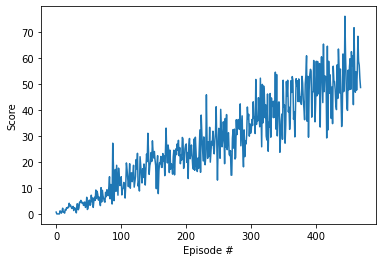

In [12]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
scores_ = []
for score in scores:
    scores_.append(score / 10)
plt.plot(np.arange(len(scores_)), scores_)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 8. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!
Copy the name of the file holding the weights into the variable `saved_weights_file`. There are 2 checkpoints provided in this project: `checkpoint.pth` we just saved from the previous cell, and `BestCheckpoint.pth` which is the result of a 2000 episodes run giving an average score of `15.82`.

In [18]:
# Choose default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Determine state and action sizes
env_info = env.reset(train_mode=False)[brain_name]
state_size = len(env_info.vector_observations[0])
action_size = brain.vector_action_space_size

# Instatiate the agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

# load the weights from file
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
agent.actor_local.load_state_dict(torch.load("checkpoint_actor.pth", map_location=map_location))
agent.critic_local.load_state_dict(torch.load("checkpoint_critic.pth", map_location=map_location))

max_episodes = 500
max_time = 1000
score_board = []

for i_episode in range(1, max_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    agent.reset()                                      # Reset Noise
    score = 0
    for t in range(max_t):
        action = agent.act(state, add_noise)           # choose the apropriate action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = 0.1 if env_info.rewards[0] > 0 else 0.0
        done = env_info.local_done[0]                  # see if episode has finished
        state = next_state
        score += reward
        if done:
            break 
    print("Episode {}\tScore: {:.2f}".format(i_episode, score))
    score_board.append(score)
print("Score Average = {:.2f}".format(np.mean(score_board)))

Episode 1	Score: 59.30
Episode 2	Score: 57.50
Episode 3	Score: 57.30
Episode 4	Score: 65.70
Episode 5	Score: 60.40
Episode 6	Score: 40.90
Episode 7	Score: 60.80
Episode 8	Score: 33.90
Episode 9	Score: 64.20
Episode 10	Score: 67.50
Episode 11	Score: 30.50
Episode 12	Score: 70.90
Episode 13	Score: 43.80
Episode 14	Score: 60.90
Episode 15	Score: 55.50
Episode 16	Score: 54.40
Episode 17	Score: 57.70
Episode 18	Score: 52.20
Episode 19	Score: 60.90
Episode 20	Score: 67.50
Episode 21	Score: 65.10
Episode 22	Score: 48.00
Episode 23	Score: 80.90
Episode 24	Score: 55.10
Episode 25	Score: 63.50
Episode 26	Score: 61.90
Episode 27	Score: 30.50
Episode 28	Score: 66.10
Episode 29	Score: 50.10
Episode 30	Score: 57.90
Episode 31	Score: 59.60
Episode 32	Score: 62.50
Episode 33	Score: 49.50
Episode 34	Score: 36.00
Episode 35	Score: 61.40
Episode 36	Score: 67.80
Episode 37	Score: 63.10
Episode 38	Score: 62.60
Episode 39	Score: 61.90
Episode 40	Score: 50.00
Episode 41	Score: 51.80
Episode 42	Score: 38.80
E

Episode 334	Score: 34.50
Episode 335	Score: 64.20
Episode 336	Score: 52.60
Episode 337	Score: 48.30
Episode 338	Score: 67.00
Episode 339	Score: 47.90
Episode 340	Score: 69.40
Episode 341	Score: 56.20
Episode 342	Score: 46.70
Episode 343	Score: 66.00
Episode 344	Score: 58.10
Episode 345	Score: 52.70
Episode 346	Score: 64.50
Episode 347	Score: 65.00
Episode 348	Score: 60.50
Episode 349	Score: 66.60
Episode 350	Score: 67.10
Episode 351	Score: 66.50
Episode 352	Score: 60.60
Episode 353	Score: 52.50
Episode 354	Score: 36.10
Episode 355	Score: 58.60
Episode 356	Score: 50.50
Episode 357	Score: 33.40
Episode 358	Score: 32.40
Episode 359	Score: 52.60
Episode 360	Score: 65.90
Episode 361	Score: 38.40
Episode 362	Score: 64.00
Episode 363	Score: 64.00
Episode 364	Score: 34.00
Episode 365	Score: 44.50
Episode 366	Score: 65.40
Episode 367	Score: 64.10
Episode 368	Score: 30.80
Episode 369	Score: 62.10
Episode 370	Score: 64.90
Episode 371	Score: 63.00
Episode 372	Score: 58.60
Episode 373	Score: 57.60


Close the environment

In [19]:
env.close()